## Предсказание уровней воды на реке Амур

In [2]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#import lightgbm as lgb
#import shap

from datetime import datetime, timedelta
#from sklearn.model_selection import rearidSearchCV

In [3]:
# Путь до папки с данными
path_to_data = '../../datasets/'

Определяем период, на который будем предсказывать (в нашем случае это первые 10 дней ноября 2019 года)

In [5]:
predict_period = ['2019-11-01', '2019-11-11'] 
f_day = datetime.strptime(predict_period[0], '%Y-%m-%d') 
l_day = datetime.strptime(predict_period[1], '%Y-%m-%d')
predict_ndays = (l_day - f_day).days

 Загрузка данных об уровнях воды на гидропостах.
 
 Датасет `daily.pkl` - собран из всех файлов `{номер_станции}_daily.csv` из папки 'datasets/', 
 номер гидропоста записан в отдельной колонке. Колонки приведены к соответствующим форматам, датасет отсортирован по (номеру гидропоста, дате)

In [6]:
daily = pd.read_pickle(path_to_data + 'processed_data/daily.pkl')
daily

,date,stage_avg,stage_min,stage_max,temp,water_code,station_id
6577,1984-01-01,258.0,258.0,258.0,NaN,NaN,5001
6578,1984-01-02,255.0,255.0,255.0,NaN,NaN,5001
6579,1984-01-03,252.0,252.0,252.0,NaN,NaN,5001
6580,1984-01-04,248.0,248.0,248.0,NaN,NaN,5001
6581,1984-01-05,244.0,244.0,244.0,NaN,NaN,5001
...,...,...,...,...,...,...,...
5628,2017-12-27,10.0,10.0,10.0,NaN,18.0,6574
5629,2017-12-28,10.0,10.0,10.0,NaN,18.0,6574
5630,2017-12-29,9.0,9.0,9.0,NaN,18.0,6574
5631,2017-12-30,9.0,9.0,9.0,NaN,18.0,6574


In [7]:
daily["station_id"].value_counts(), len(daily["station_id"].unique())

(5740    12686
 5319    12447
 5321    12447
 5331    12447
 6030    12419
         ...  
 6001      730
 5395      518
 6545      396
 6573      273
 5408       92
 Name: station_id, Length: 198, dtype: int64,
 198)

In [8]:
daily = daily.sort_values(by=['station_id','date'])
daily = daily.reset_index(drop=True)

In [8]:
# Выбираем целевые гидрологические посты
target_station_ids = [6005, 6022, 6027, 5004, 5012, 5024, 5805]

In [9]:

daily = daily[daily['station_id'].isin(target_station_ids)]

Посмотрим как выглядит ряд для фиксированного `station_id`

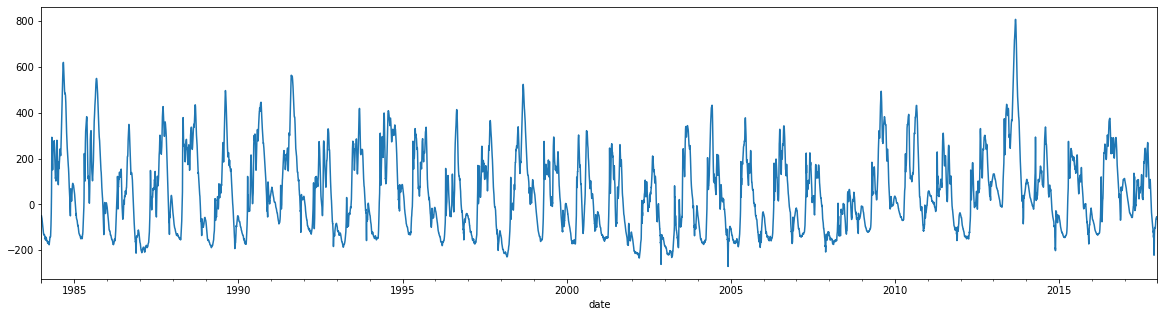

In [10]:
daily = daily.set_index('date')
daily.loc[daily['station_id'] == 5012, 'stage_max'].plot(figsize=(20, 5))
daily = daily.reset_index()

Загрузим и приведем к соответствующим форматам свежие данные по целевым вышкам, которые находятся в файле `datasets/hydro2019-20/new_data.csv`

In [11]:
nf = pd.read_csv(path_to_data + 'hydro_2018-2020/new_data_target.csv', sep=';')
nf.head()

,time,max_level,identifier
0,2020-10-01 00:00:00,799.0,5004
1,2020-10-01 00:00:00,203.0,5805
2,2020-10-01 00:00:00,704.0,5024
3,2020-10-01 00:00:00,521.0,5012
4,2020-10-01 00:00:00,363.0,6005


In [12]:
nf['time'] = pd.to_datetime(nf['time'], format='%Y-%m-%d %H:%M:%S')
nf.columns = ['date', 'stage_max', 'station_id']
nf = nf.sort_values(by=['station_id', 'date'])
nf = nf.set_index('date')
nf = nf[nf.index > '2017-12-31']

Посмотрим на графики новых данных:

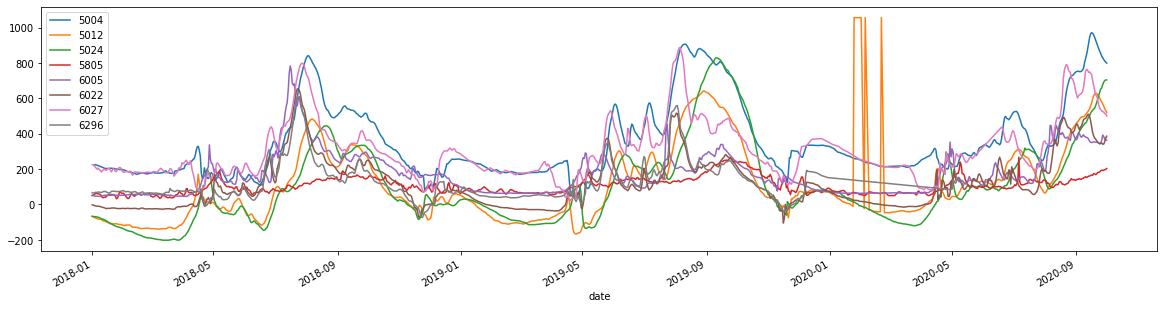

In [13]:
plt.figure(figsize=(20,5))
leg = []
for st in nf.station_id.unique():
    sf = nf[nf['station_id'] == st]
    sf['stage_max'].plot()
    leg.append(st)
plt.legend(leg)

Удалим выбросы у гидрологичского поста с номером 5012

In [14]:
nf.loc[(nf['stage_max'] > nf['stage_max'].\
          quantile(0.99))&(nf['station_id'] == 5012), 'stage_max'] = np.nan

<AxesSubplot:xlabel='date'>

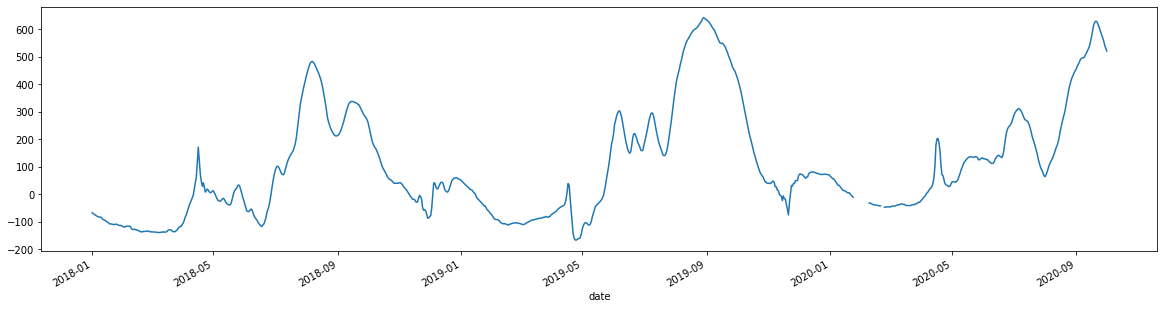

In [15]:
sf = nf[nf['station_id'] == 5012]
sf['stage_max'].plot(figsize=(20,5))

Приведем индексы к такому же виду как в daily и соеденим датасеты 

In [16]:
nf = nf.reset_index()
nf = nf.reindex(['date', 'stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'station_id'], axis=1)
daily = pd.concat([daily, nf], axis=0)
daily = daily.sort_values(by=['station_id', 'date'])

In [17]:
daily

,date,stage_avg,stage_min,stage_max,temp,water_code,station_id
0,1984-01-01,112.0,112.0,112.0,NaN,3.0,5004
1,1984-01-02,118.0,118.0,118.0,NaN,3.0,5004
2,1984-01-03,134.0,134.0,134.0,NaN,3.0,5004
3,1984-01-04,149.0,149.0,149.0,NaN,3.0,5004
4,1984-01-05,156.0,156.0,156.0,NaN,3.0,5004
...,...,...,...,...,...,...,...
6779,2020-05-08,NaN,NaN,151.0,NaN,NaN,6296
6780,2020-05-09,NaN,NaN,141.0,NaN,NaN,6296
6781,2020-05-10,NaN,NaN,130.0,NaN,NaN,6296
6782,2020-05-11,NaN,NaN,117.0,NaN,NaN,6296


### Метеоданные 
Загрузка метеоданных, соответстующих целевым гидрологическим постам. 

Используемый датасет `s2m.pkl` - (station_to_meteo) - это таблица в которой номеру гидрологического поста поставлен в соответсвие номер ближайшей метеостанции, а так же указано расстояние до неё. Координаты гидрологических постов и метеостанций взяты из http://asunp.meteo.ru/geoits-rest/services/asunp/geo.json

In [4]:
s2m = pd.read_pickle(path_to_data + 'processed_data/s2m.pkl')
s2m.head()

,meteo_id,dist
station_id,,
5674,4943321,81.846330
5216,4433241,21.467114
6256,5172691,62.347672
5132,4483421,27.216443
5151,4393311,1.111949


Пример таблицы с метеоданными

In [5]:
pd.read_csv(path_to_data + 'meteo/4263131.csv', sep=';').head()

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,...,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time
0,GAMOV,4263131,NaN,6,254.0,0,5.0,0,NaN,7.0,...,NaN,NaN,5,NaN,6,1.2,0,76.0,0,2013-04-17 21:00:00
1,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 18:00:00
2,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 15:00:00
3,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 12:00:00
4,GAMOV,4263131,NaN,6,233.0,0,7.0,0,NaN,10.0,...,NaN,NaN,5,NaN,6,3.4,0,75.0,0,2013-04-17 09:00:00


In [6]:
# Вспомогательная функция для соединения идентичных датафреймов 
def weary_append(x,y):
    if x is not None:
        if any([a for a in list(x.columns) if a not in y.columns]) or any([a for a in list(y.columns) if a not in x.columns]):
            raise ValueError()
        else:
            return x.append(y)
    else:
        return y

Считываем файлы с метеоданными, соответствующие целевым гидрологическим постам. Номер метеостанции записываем в колонку `meteo_id`, а номер гидрологического поста в `station_id`

In [16]:
meteo = None
for s, m in s2m.loc[target_station_ids][['meteo_id']].iterrows():
    m = m.values[0]
    df = pd.read_csv(path_to_data + 'meteo/{}.csv'.format(m), sep=';').rename({'station_id': 
                                                                                        'meteo_id'}, axis=1)
    df['datetime'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df['date'] = df['datetime'].apply(lambda x: x.date())
    df['station_id'] = s
    meteo = weary_append(meteo, df)

In [12]:
meteo.head()

,station_name,meteo_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,...,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time,datetime,date,station_id
0,DJALI25,5352391,96.0,0,315.0,0,4.0,0,NaN,6.0,...,-1.3,0,-5.7,0,87.0,0,2013-04-17 21:00:00,2013-04-17 21:00:00,2013-04-17,6005
1,DJALI25,5352391,NaN,5,315.0,0,4.0,0,NaN,6.0,...,-1.4,0,-4.7,0,63.0,0,2013-04-17 18:00:00,2013-04-17 18:00:00,2013-04-17,6005
2,DJALI25,5352391,NaN,5,315.0,0,4.0,0,NaN,7.0,...,-0.8,0,-2.5,0,49.0,0,2013-04-17 15:00:00,2013-04-17 15:00:00,2013-04-17,6005
3,DJALI25,5352391,NaN,5,315.0,0,3.0,0,NaN,4.0,...,-1.2,0,-0.9,0,99.0,0,2013-04-17 12:00:00,2013-04-17 12:00:00,2013-04-17,6005
4,DJALI25,5352391,96.0,0,315.0,0,3.0,0,NaN,4.0,...,0.4,0,-0.1,0,96.0,0,2013-04-17 09:00:00,2013-04-17 09:00:00,2013-04-17,6005


Согласно описанию данных (а именно файл Время_85.docx) данные до '1993-1-1' записывались по GMT+3, поэтому переведем их к Гринвичу

In [188]:
meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'] = \
    meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'].apply(lambda x: x - timedelta(hours=3))

Усреднение температурных признаков по (времени суток, дате)

In [189]:
meteo = meteo.set_index('datetime')
meteo[meteo.index.month==3].groupby(meteo[meteo.index.month==3].index.hour)['temperature_air'].mean()

datetime
0    -10.401762
3     -5.039252
6     -2.809799
9     -3.957306
12    -7.727059
15   -10.338852
18   -12.013950
21   -13.245664
Name: temperature_air, dtype: float64

In [190]:
meteo['night'] = (meteo.index.hour > 14) | (meteo.index.hour < 2)
# print(len(meteo))
dmeteo = meteo.groupby(['station_id', 'date', 'night'])[['temperature_air', 
                                                    'temperature_ground']].mean().reset_index(level=2)
# print(len(dmeteo))
dmeteo = dmeteo.pivot(columns='night')
ncols = []
for col in dmeteo.columns:
    if col[1]:
        prefix = 'night_'
    else:
        prefix = 'day_'
    ncols.append(prefix + col[0])
dmeteo.columns = ncols
# print(len(dmeteo))

Получили датасет со средней ночной и дневной температурой воздуха и почвы за каждый день.

In [191]:
dmeteo.head()

day_temperature_air  night_temperature_air  \
station_id date                                                     
5004       1985-01-01              -17.900                -24.400   
           1985-01-02              -16.775                -26.250   
           1985-01-03              -18.975                -24.650   
           1985-01-04              -19.150                -26.050   
           1985-01-05              -21.200                -27.675   

                       day_temperature_ground  night_temperature_ground  
station_id date                                                          
5004       1985-01-01                 -19.950                   -27.275  
           1985-01-02                 -19.725                   -29.375  
           1985-01-03                 -19.900                   -26.900  
           1985-01-04                 -19.900                   -28.175  
           1985-01-05                 -21.775                   -28.175

meteo.index.dateЗначения влажности воздуха беру среднее за сутки, а кол-во осадков - максимальное

In [192]:
# meteo[(meteo["station_name"] == "DJALI25")&(meteo.index.date==pd.to_datetime("2015-09-20", format="%Y-%m-%d"))][["humidity", "precipitation_amount"]]

In [193]:
meteo["precipitation_amount"].value_counts(), f"'Not None' counts: {meteo['precipitation_amount'].notnull().sum()}"

(0.0     13235
 0.3      3257
 0.4      2448
 0.2      2417
 0.5      1769
         ...  
 62.5        1
 63.3        1
 71.5        1
 45.6        1
 80.8        1
 Name: precipitation_amount, Length: 484, dtype: int64,
 "'Not None' counts: 51332")

In [194]:
dmeteo[['humidity', 'precipitation_amount']] = \
meteo.groupby(['station_id', 'date'])[['humidity', 'precipitation_amount']].agg({'humidity': 'mean', 
                                                                                 'precipitation_amount': 'max'})

In [195]:
dmeteo["precipitation_amount"].isnull().sum(), len(dmeteo)

(51428, 86895)

In [196]:
null_mask = dmeteo["precipitation_amount"].isnull()
station_id_mask = dmeteo.index.get_level_values(0) == target_station_ids[6]

dmeteo[null_mask&station_id_mask].index.get_level_values(1).unique()

Index([1985-01-01, 1985-01-02, 1985-01-07, 1985-01-08, 1985-01-09, 1985-01-10,
       1985-01-11, 1985-01-12, 1985-01-14, 1985-01-15,
       ...
       2018-12-07, 2018-12-11, 2018-12-12, 2018-12-13, 2018-12-14, 2018-12-15,
       2018-12-16, 2018-12-21, 2018-12-22, 2018-12-31],
      dtype='object', name='date', length=7173)

Реализуем функцию, которая будет аггрегировать метео признаки по заданному количеству дней, заданной функцией и сдвигать на заданное число дней

In [197]:
def agg_meteo(df, 
              columns = ['day_temperature_air', 'night_temperature_air', 'day_temperature_ground', 
                         'night_temperature_ground', 'humidity','precipitation_amount'],
              agg_days = [15, 15, 15, 15, 10, 60],
              agg_funcs = ['mean', 'mean', 'mean', 'mean', 'sum', 'sum'],
              shift = [10, 10, 10, 10, 10, 10]):
    res = pd.DataFrame(index=df.index)
    names = []
    for c, d, f, s in zip(columns, agg_days, agg_funcs, shift):
        name = '{}_{}_{}'.format(c, d, s)
        res[name] = df[c].rolling(d, min_periods=1).agg(f).shift(s)
        names.append(name)
    return res.reset_index(), names

In [198]:
agg, meteo_feats = agg_meteo(dmeteo)
agg['date'] = pd.to_datetime(agg['date'])

In [199]:
meteo_feats

['day_temperature_air_15_10',
 'night_temperature_air_15_10',
 'day_temperature_ground_15_10',
 'night_temperature_ground_15_10',
 'humidity_10_10',
 'precipitation_amount_60_10']

Присоединяем метеоданные к посуточным замерам уровней

In [200]:
daily = daily.merge(agg, on=['station_id', 'date'], how='left')

In [201]:
daily.shape

(93596, 13)

Создаем "календарные" признаки

In [202]:
daily = daily.set_index('date')
daily['year'] = daily.index.year
daily['month'] = daily.index.month
daily['day'] = daily.index.day
daily['doy'] = daily.index.dayofyear
daily = daily.reset_index()

По графикам можно наблюдать некую годовую сезонность в значениях уровня воды. Поэтому, могут оказаться полезными признаки: значения уровня воды последние годы в предсказываемые даты.

In [203]:
# Вспомогательная функция, прибавляющая года в кол-ву years к дате d
def add_years(d, years):
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        return d + (datetime(d.year + years, 1, 1) - datetime(d.year, 1, 1))

In [204]:
# Цикл по количеству рассматриваемых лет
past = []
for y in range(1, 6):
    daily['ndate'] = daily['date'].apply(lambda x: add_years(x, y))
    hf = daily[['ndate', 'station_id', 'stage_max']].rename({'ndate': 'date', 'stage_max': 
                                                             'past_{}'.format(y)}, axis=1)
    
#     Удаление дубликатов, появляющихся из-за 29 февраля
    hf = hf.set_index(['station_id', 'date']) 
    hf = hf[~hf.index.duplicated(keep='first')]
    hf = hf.reset_index()
    
    daily = daily.merge(hf, on=['station_id', 'date'], how='left').drop('ndate', axis=1)
#     Цикл по датам целевого периода
    for i in range(predict_ndays+1):
        daily['past_{}_{}'.format(y, i)] = daily['past_{}'.format(y)].shift(-i)
        past.append('past_{}_{}'.format(y, i))
    daily.drop('past_{}'.format(y), axis=1, inplace=True)

       station_id       date  past_1
0            5004 1985-01-01   112.0
1            5004 1985-01-02   118.0
2            5004 1985-01-03   134.0
3            5004 1985-01-04   149.0
4            5004 1985-01-05   156.0
...           ...        ...     ...
93528        6296 2021-05-08   151.0
93529        6296 2021-05-09   141.0
93530        6296 2021-05-10   130.0
93531        6296 2021-05-11   117.0
93532        6296 2021-05-12   107.0

[93533 rows x 3 columns]
       station_id       date  past_2
0            5004 1986-01-01   112.0
1            5004 1986-01-02   118.0
2            5004 1986-01-03   134.0
3            5004 1986-01-04   149.0
4            5004 1986-01-05   156.0
...           ...        ...     ...
93528        6296 2022-05-08   151.0
93529        6296 2022-05-09   141.0
93530        6296 2022-05-10   130.0
93531        6296 2022-05-11   117.0
93532        6296 2022-05-12   107.0

[93533 rows x 3 columns]
       station_id       date  past_3
0            5004 1987-

Осталось добавить признаки временного ряда, то есть значения таргета за ndays предыдущих дней. Но, так как в исходных датасетах встречаются пропущенные даты, их надо сначала заполнить NaN'ми. Для этого воспользуемся методом .date_range и .reindex

In [161]:
daily = daily.set_index(['station_id', 'date'])
new_index = pd.MultiIndex.from_product([daily.index.get_level_values(0).unique(), 
                                        pd.date_range('1984-1-1', '2020-10-01')])
daily = daily.reindex(new_index)

Создание признаков временного ряда

In [163]:
ndays = 20

In [164]:
daily['target'] = daily['stage_max']
ts = []
for i in range(ndays, 0, -1):
    daily['ts_{}'.format(i)] = daily.groupby('station_id')['stage_max'].shift(i)
    ts.append('ts_{}'.format(i))
# daily.drop('stage_max', axis=1, inplace=True)

Выкидываем строки в которых таргет NaN

In [165]:
daily = daily[daily['target'].notna()]

In [169]:
daily.columns

Index(['stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'day_temperature_air_15_10', 'night_temperature_air_15_10',
       'day_temperature_ground_15_10', 'night_temperature_ground_15_10',
       'humidity_10_10', 'precipitation_amount_60_10', 'year', 'month', 'day',
       'doy', 'past_1_0', 'past_1_1', 'past_1_2', 'past_1_3', 'past_1_4',
       'past_1_5', 'past_1_6', 'past_1_7', 'past_1_8', 'past_1_9', 'past_1_10',
       'past_2_0', 'past_2_1', 'past_2_2', 'past_2_3', 'past_2_4', 'past_2_5',
       'past_2_6', 'past_2_7', 'past_2_8', 'past_2_9', 'past_2_10', 'past_3_0',
       'past_3_1', 'past_3_2', 'past_3_3', 'past_3_4', 'past_3_5', 'past_3_6',
       'past_3_7', 'past_3_8', 'past_3_9', 'past_3_10', 'past_4_0', 'past_4_1',
       'past_4_2', 'past_4_3', 'past_4_4', 'past_4_5', 'past_4_6', 'past_4_7',
       'past_4_8', 'past_4_9', 'past_4_10', 'past_5_0', 'past_5_1', 'past_5_2',
       'past_5_3', 'past_5_4', 'past_5_5', 'past_5_6', 'past_5_7', 'past_5_8',
   

## Обучение

Для кросс-валидации использум деление выборки на __train__: до *f_day* i-го года; __test__: _predictperiod_ i-го года, где i пробегает 5 последних лет, имеющихся в тренировочной выборке.

In [166]:
# Генератор индексов для кросс-валидации
def train_test_fold(df, f_day, l_day):
    for year in [f_day.year - 5 + i for i in range(5)]:
        f = '{}-{}'.format(year, datetime.strftime(f_day, '%m-%d'))
        l = '{}-{}'.format(year, datetime.strftime(l_day, '%m-%d'))
        yield df.index[df.index < f], df.index[(df.index>=f)&(df.index<l)]

Реализация функции пошагового предсказания.
На вход подается:
- `model` - обученная модель
- `ts_data` - значения таргета за последние _ndays_ тренировочной выборки
- `test_data` - дополнительные признаки, в тестовый период (признаки не должны зависеть от значений, которые могут быть получены только в тестовый период. Поэтому, например, все погодные признаки сдвинуты на _predict_ndays_ вперед)
- `features` - список названий доп. признаков
- `n` - количество дней, на которые строится предказание

In [205]:
def steps_predict(model, ts_data, test_data, features, n):
    isfeat = len(features) > 0
    test_features = test_data[features].values
    if isfeat:
        data = np.r_[test_features[0], ts_data].reshape(1,-1)
    else:
        data = ts_data.reshape(1,-1)
    predict = []
    predict.append(model.predict(data)[0])

    for i in range(1, n):
        ts_data = np.r_[ts_data[1:], predict[i-1]]
        if isfeat:
            data = np.r_[test_features[i], ts_data].reshape(1,-1)
        else:
            data = ts_data.reshape(1,-1)
        predict.append(model.predict(data)[0])
    return np.array(predict)

In [206]:
def metrics(true, pred, station_id, printit=False):
    mae = np.mean(np.abs(pred - true))   
    if printit:
        print("MAE: {}".format(mae))
    return mae

In [207]:
def plot_predict(true, pred, station_id=None):
    plt.figure(figsize=(20, 5))
    plt.plot(true)
    plt.plot(pred)
    leg = ['true values', 'predict values']
    
    plt.legend(leg)
    if station_id is not None:
        plt.title(station_id)
    plt.show()

Реализация собственной функции кросс-валидации модели. Разбиения строятся с помощью 
*train_test_fold(df, f_day, l_day)*. В качестве ошибки на валидационной выборке будем использовать метрику $MAE$

In [208]:
def cross_val(model, dataset, gen, target_name, features, lag, predict_ndays, 
              station_id, ts, eval_metric='wmae2', plotit=False):
    mae_list = []
    rmse_list = []
    wmae_list = []
    wmae2_list = []
    for i in range(5):
        train_idx, test_idx = next(gen)
        X_train = dataset.loc[train_idx].sort_index()
        X_test = dataset.loc[test_idx].sort_index()

        X = X_train[features + ts].copy()
        y = X_train[target_name]
        
        if eval_metric == 'wmae2':
            eval_metr = lambda x, y: ['wmae2', comp_wmae2(x, y, station_id), True]
        else:
            eval_metr = eval_metric
        model.fit(X, y)
        
        ts_data = X_train[target_name].values[-lag:]
        predict = steps_predict(model, ts_data, X_test, features, predict_ndays)
        if target_name == 'delta':
            predict = X_test['mean_by_date'].values + predict
        true = X_test[target_name].values
        mae = metrics(true, predict,station_id)
        mae_list.append(mae)

        if plotit:
            plot_predict(true, predict, station_id=station_id)
    res_table = pd.DataFrame([mae_list, rmse_list, wmae2_list], 
                        index=['MAE', 'RMSE', 'WMAE2'],
                        columns = ['fold{}'.format(i) for i in range(1, 6)])
    return res_table

Посмотрим на степень влияния дополнительных признаков на результат работы модели. Для этого воспользуемся библиотекой `shap` https://shap.readthedocs.io/en/latest/index.html 

Обучение LGBM с дефолтными параметрами и всеми доп. признакими.

In [209]:
all_features = meteo_feats + ['year', 'month', 'doy'] + past
station_id = 5012
features = all_features

sf = daily.loc[station_id]
model_lgb = lgb.LGBMRegressor(random_state=33)
X_train = sf.loc[sf.index < f_day, features]
y_train = sf.loc[sf.index < f_day, 'target']
X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
model_lgb.fit(X_train, y_train)

NameError: name 'lgb' is not defined

In [46]:
X_importance = X_train
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)

In [47]:
X_train

,day_temperature_air_15_10,night_temperature_air_15_10,day_temperature_ground_15_10,night_temperature_ground_15_10,humidity_10_10,precipitation_amount_60_10,year,month,doy,past_1_0,...,past_5_1,past_5_2,past_5_3,past_5_4,past_5_5,past_5_6,past_5_7,past_5_8,past_5_9,past_5_10
1984-01-01,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-02,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-03,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,300.0,40.0,...,-63.0,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0
2019-10-28,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,301.0,40.0,...,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0
2019-10-29,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,302.0,40.0,...,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0,-94.0
2019-10-30,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,303.0,40.0,...,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0,-94.0,-93.0


Построения графика важности дополнительных признаков.

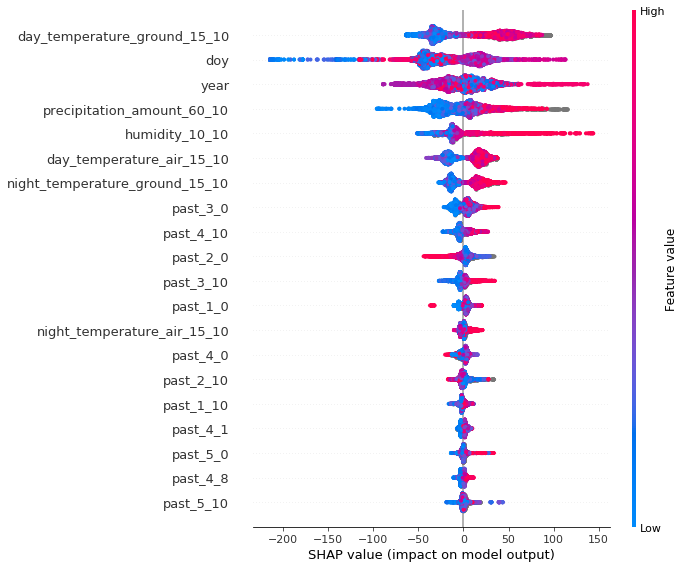

In [48]:
shap.summary_plot(shap_values, X_importance)

Из графика видно, что метеопризнаки довольно сильно влияют на целевое значение. Например, 
как и ожидалось, признак `precipitation_amount_60_10` - накопленные осадки за 60 дней, 10 дней назад при больших значениях дает положительный вклад в целевое значение, а при малых - отрицательный. Тот же эффект виден для `humidity_10_10` - накопленная влажность воздуха за 10 дней, 10 дней назад.

In [49]:
predict = model_lgb.predict(X_test)
true = y_test.values
metrics(true, predict, station_id)

32.75925779577402

###  GridSearch для поиска параметров модели

Простая функция для поиска трех основных параметров модели обучения:

In [50]:
def grid_search(df, params, features, ndays, predict_ndays, station_id, ts):
    best_metric = 500
    for ne in params['n_estimators']:
        for lr in params['learning_rate']:
            for nl in params['num_leaves']:
                model_lgb = lgb.LGBMRegressor(n_estimators=ne,
                                              learning_rate=lr,
                                              num_leaves=nl,
                                              random_state=33)
                gen = train_test_fold(sf, f_day, l_day)
                res = cross_val(model_lgb, df, gen, 'target', features, ndays, 
                                predict_ndays, station_id, ts, 'wmae2', plotit=False)
                metric = res.mean(axis=1)['MAE']
                if metric < best_metric:
                    best_metric = metric
                    best_params = dict(zip(params.keys(), [ne, lr, nl]))
    return best_params

In [51]:
grid_params = {
    'n_estimators': [30, 70, 110],
    'learning_rate': [0.05, 0.1, 0.12],
    'num_leaves': [27, 31, 37]
}

In [55]:
model_params = {}
for station_id in tarrget_station_ids:
    sf = daily.loc[station_id].copy()
    features = all_features
    model_params[station_id] = grid_search(sf, grid_params, features, ndays, predict_ndays, station_id, ts)

### Результаты
В следующей ячейки собирается таблица с результатами предсказаний `sample_submission`. 

Построены графики с предсказанными и настоящими значениями и выведено значение метрики для каждого гидрологического поста.

6005  MAE:  9.294121061105663


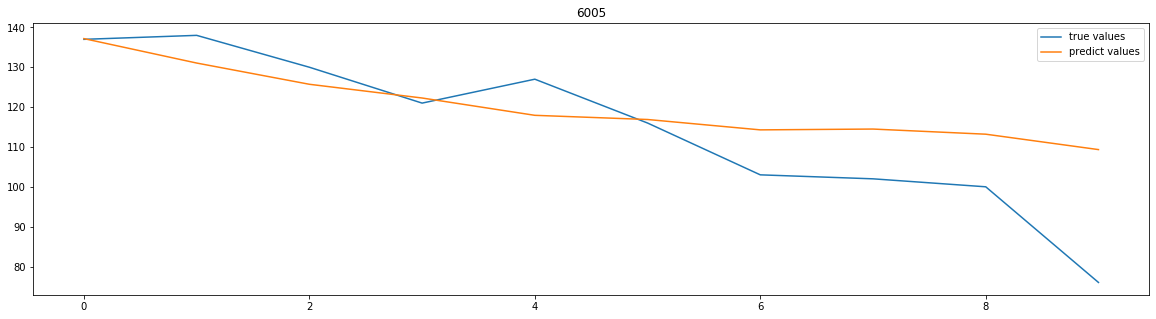

6022  MAE:  10.762157403047734


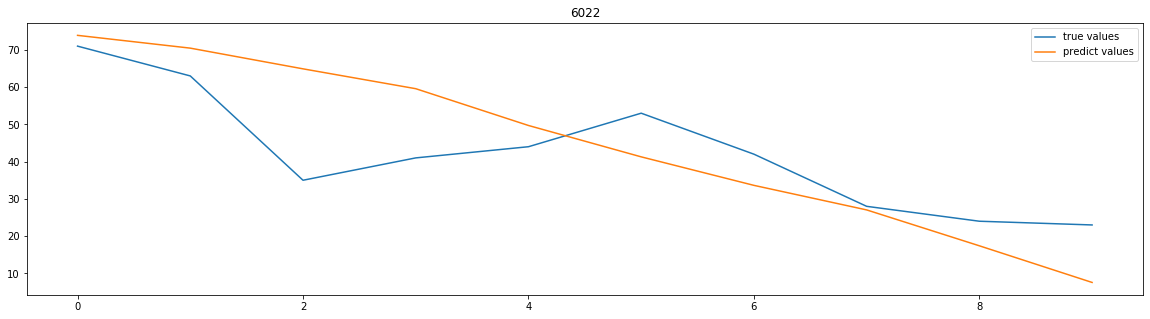

6027  MAE:  17.37000850318993


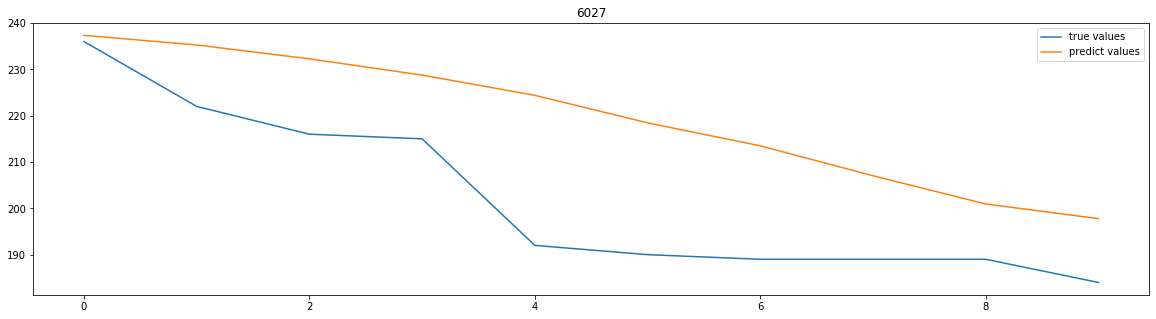

5004  MAE:  23.245771608120506


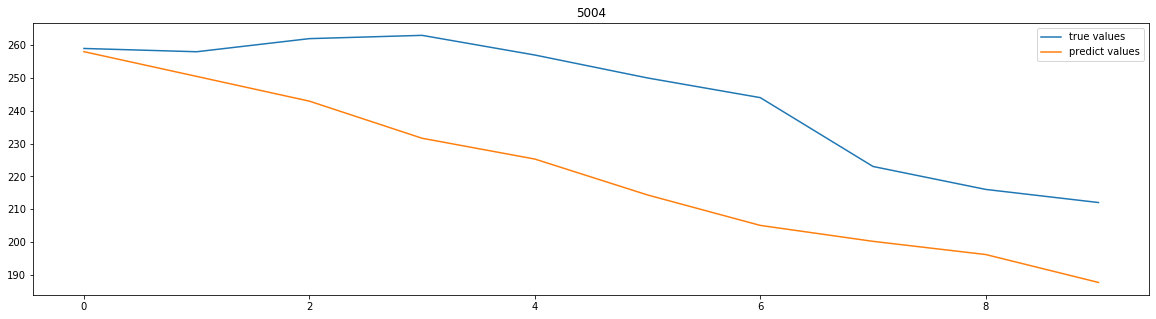

5012  MAE:  28.334837838429642


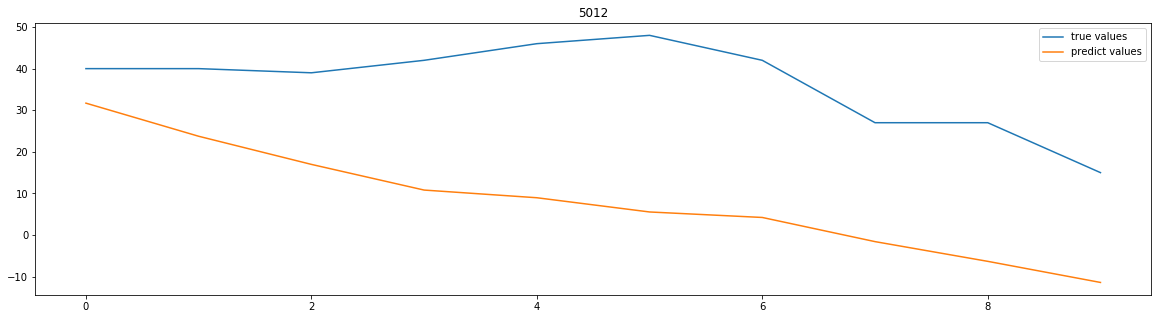

5024  MAE:  27.873136097752866


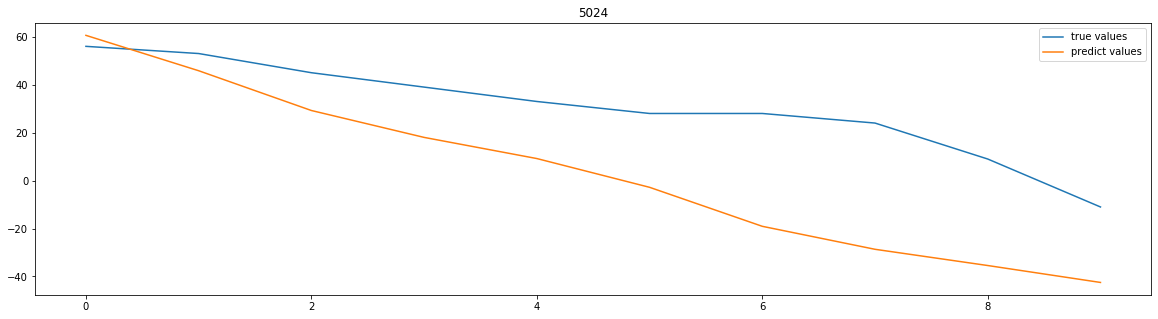

5805  MAE:  17.30985694165212


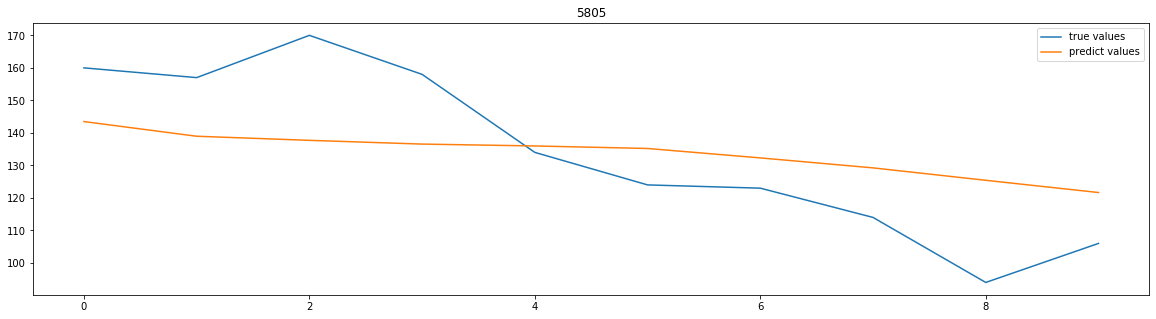

In [57]:
sample_submission = pd.DataFrame(index=pd.date_range(f_day, l_day - timedelta(1)))
lgbm_metrics = {}
for key in model_params:
    station_id = int(key)
    params = model_params[key]
    model_lgb = lgb.LGBMRegressor(n_estimators=params['n_estimators'],
                              learning_rate=params['learning_rate'],
                              num_leaves=params['num_leaves'],
                              random_state=33)
    sf = daily.loc[int(key)]
    X_train = sf.loc[sf.index < f_day, features + ts]
    y_train = sf.loc[sf.index < f_day, 'target']
    X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
    y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
    model_lgb.fit(X_train, y_train)
    ts_data = y_train.values[-ndays:]
    predict = steps_predict(model_lgb, ts_data, X_test, features, predict_ndays)
    sample_submission[key] = predict # запись результата в таблицу
    mae = metrics(y_test.values, predict, station_id)
    lgbm_metrics[station_id] = [mae]
    print(station_id, ' MAE: ', mae)
    plot_predict(y_test.values, predict, station_id)

Сформируем файл с результатом

In [58]:
sample_submission

,6005,6022,6027,5004,5012,5024,5805
2019-11-01,137.180847,73.893699,237.335707,258.026344,31.702432,60.584309,143.482483
2019-11-02,131.052637,70.462655,235.262273,250.476695,23.743919,45.830590,138.970330
2019-11-03,125.724605,64.905716,232.271498,242.930538,16.981014,29.237060,137.706250
2019-11-04,122.279553,59.576472,228.756903,231.607687,10.808647,18.019441,136.556078
2019-11-05,117.935110,49.700498,224.390524,225.262621,8.963131,9.195799,135.982544
2019-11-06,116.885918,41.280337,218.448764,214.306641,5.542228,-2.798273,135.205623
2019-11-07,114.283529,33.629421,213.493173,205.020523,4.221850,-19.067208,132.309224
2019-11-08,114.489074,27.037855,207.029381,200.156657,-1.585288,-28.655171,129.239393
2019-11-09,113.199359,17.402628,200.935507,196.134647,-6.326629,-35.426402,125.418551
2019-11-10,109.335281,7.567224,197.776354,187.619932,-11.399683,-42.482888,121.658376


Сохранение результата

In [59]:
sample_submission.to_csv('sample_submission.csv')